In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_predict,cross_val_score,cross_validate, learning_curve, GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.linear_model import SGDClassifier, RidgeClassifier, LogisticRegression, LogisticRegressionCV, RidgeClassifierCV

from sklearn.metrics import log_loss, ConfusionMatrixDisplay, precision_recall_curve, precision_score, recall_score, classification_report, auc, accuracy_score, roc_auc_score, roc_curve

from scipy.stats import loguniform

%matplotlib inline
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.metrics import log_loss



In [2]:
def warn(*args, **kwargs):
    pass
import warnings

warnings.warn=warn

#### Classification steps
- Preprocessing
- Classification
- cross validation train
- hyper-parameter tuning
- performance evaluation

## Handwritten Digit Classifier

In [3]:
from sklearn.datasets import fetch_openml
X_pd, y_pd=fetch_openml('mnist_784', version=1, return_X_y=True)

X=X_pd.to_numpy()
y=y_pd.to_numpy()

In [4]:
#split
X_train,X_test,y_train,y_test= X[:60000],X[60000:], y[:60000],y[60000:]

### Pre-Processing

- sigmoid requires feature scaling between 0 to 1
- Warning: Do not apply <i>mean centering</i> as it removes zeros from the data, however, zeros should be zeros in the dataset.


### Binary Classification- 0 detector

- The original label vector contains <b>10 classes</b> and we need to modify it to <b>2</b>
- label 0 will be changed to 1 and everything except 0(1-9) to 0

In [5]:
y_train_0=np.zeros(len(y_train))
y_test_0=np.zeros(len(y_test))

idx_0=np.where(y_train=='0')
y_train_0[idx_0]=1

idx_0=np.where(y_test=='0')
y_test_0[idx_0]=1

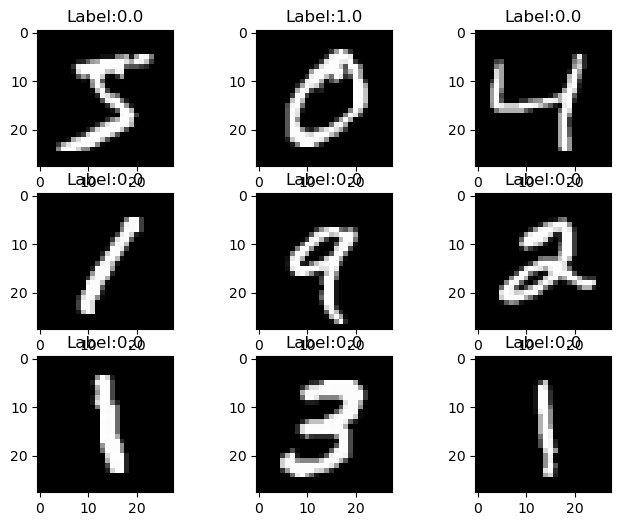

In [6]:
fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(8, 6))
num_images = 9
# Flatten the axes array to make indexing easier
factor = np.int8(np.sqrt(num_images))
idx_offset = 0 
for i in range(factor):
    index=idx_offset + i*(factor)
    for j in range(factor):
        ax[i,j].imshow(X[index+j].reshape(28,28),cmap='gray')
        ax[i,j].set_title('Label:{0}'.format(str(y_train_0[index+j])))

# SGD classifier

In [67]:
estimator= SGDClassifier(loss='log_loss',penalty='l2',max_iter=1,warm_start=True, eta0=0.01,learning_rate='constant',alpha=0, random_state=42 )

min_max=MinMaxScaler() # 0 to 1

sgd_pipe=Pipeline([
    
    ("min_max",min_max),
    ("sgd",estimator)
])


In [82]:

#plotting the LEARNING Curve
Loss=[]

for i in range(100):
    sgd_pipe.fit(X_train,y_train_0)
    y_train_proba=sgd_pipe.predict_proba(X_train)
    Loss.append(log_loss(y_train_0,y_train_proba))



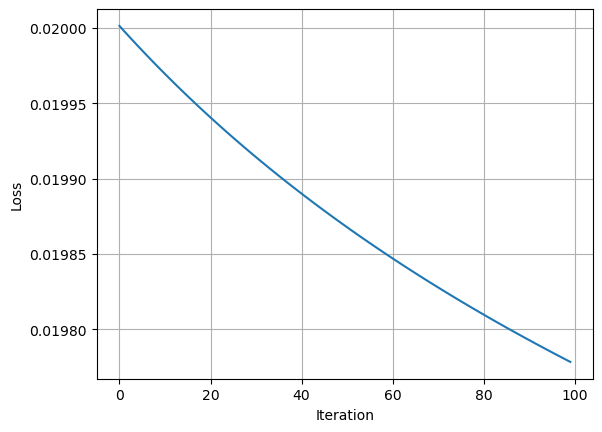

In [83]:
iterations=100
plt.plot(np.arange(iterations),Loss)
plt.grid(True)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

In [92]:
#training and test accuracy
# accuracy_score(y_train_0,sgd_pipe.predict(y_train_0))
print(f''''train accuracy score:{sgd_pipe.score(X_train,y_train_0):.2f}''')
print(f''''test accuracy score:{sgd_pipe.score(X_test,y_test_0):.2f}''')

'train accuracy score:0.99
'test accuracy score:0.99


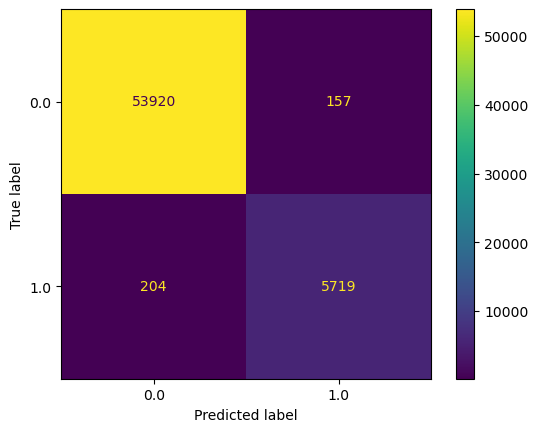

In [94]:
#precision, recall and f1 score
y_hat_train_0=sgd_pipe.predict(X_train)
cm_display=ConfusionMatrixDisplay.from_predictions(y_train_0,y_hat_train_0,values_format='.5g')
plt.show()


In [95]:

print(classification_report(y_train_0, y_hat_train_0, digits=3))

              precision    recall  f1-score   support

         0.0      0.996     0.997     0.997     54077
         1.0      0.973     0.966     0.969      5923

    accuracy                          0.994     60000
   macro avg      0.985     0.981     0.983     60000
weighted avg      0.994     0.994     0.994     60000



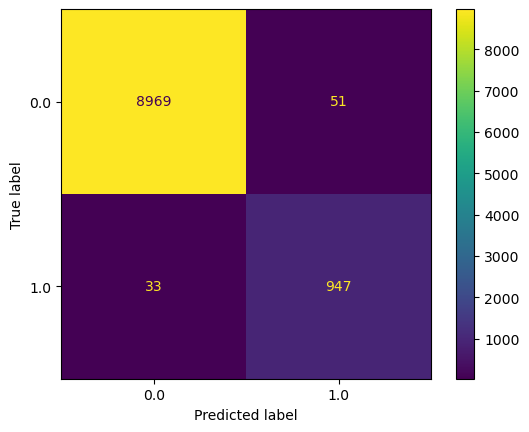

In [96]:
# similarly for the test dataset

y_hat_test_0=sgd_pipe.predict(X_test)
cm_test_display=ConfusionMatrixDisplay.from_predictions(y_test_0,y_hat_test_0,values_format='.5g')


In [97]:
print(classification_report(y_test_0,y_hat_test_0))

              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00      9020
         1.0       0.95      0.97      0.96       980

    accuracy                           0.99     10000
   macro avg       0.97      0.98      0.98     10000
weighted avg       0.99      0.99      0.99     10000



In [99]:
#cross validation
estimator = SGDClassifier(loss='log_loss',
                        penalty='l2',
                        max_iter=100,
                        warm_start=False,
                        eta0=0.01,
                        alpha=0,
                        learning_rate='constant',
                        random_state=1729)

# create a pipeline
pipe_sgd_cv = make_pipeline(MinMaxScaler(),estimator)

sgd_clf_cv=cross_validate(estimator,X_train,y_train_0,cv=5,scoring=['precision','recall','f1'], return_train_score=True)
sgd_clf_cv

{'fit_time': array([1.72663498, 1.57098293, 1.36496091, 0.98995256, 1.66976786]),
 'score_time': array([0.0575099 , 0.06177497, 0.06322098, 0.04614711, 0.04060316]),
 'test_precision': array([0.83901378, 0.96265938, 0.94834886, 0.9638009 , 0.95233969]),
 'train_precision': array([0.84987184, 0.97356929, 0.95712484, 0.98198814, 0.97258486]),
 'test_recall': array([0.97719595, 0.89273649, 0.94514768, 0.89873418, 0.92742616]),
 'train_recall': array([0.97953155, 0.89385946, 0.96116505, 0.90903335, 0.94343605]),
 'test_f1': array([0.90284822, 0.92638037, 0.94674556, 0.930131  , 0.93971783]),
 'train_f1': array([0.91010685, 0.9320132 , 0.95914069, 0.94410346, 0.95778873])}

In [102]:
weights = sgd_pipe[1].coef_
bias = sgd_pipe[1].intercept_
print('Dimention of Weights w: {0}'.format(weights.shape))
print('Bias :{0}'.format(bias))

Dimention of Weights w: (1, 784)
Bias :[-4.91481033]


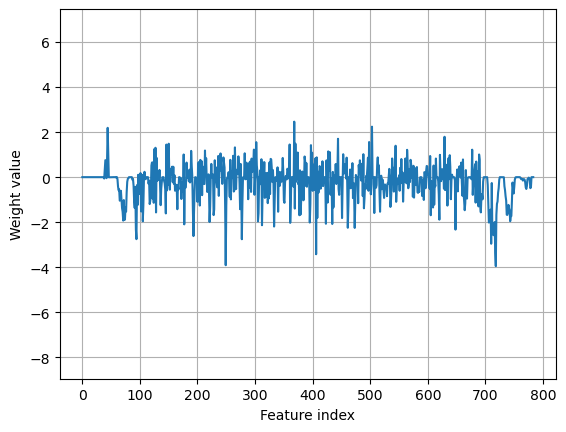

In [103]:
plt.figure()
plt.plot(np.arange(0,784),weights[0,:])
plt.xlabel('Feature index')
plt.ylabel('Weight value')
plt.ylim((np.min(weights)-5, np.max(weights)+5))
plt.grid()

#### Training with regularization

ValueError: x and y must have same first dimension, but have shapes (100,) and (200,)

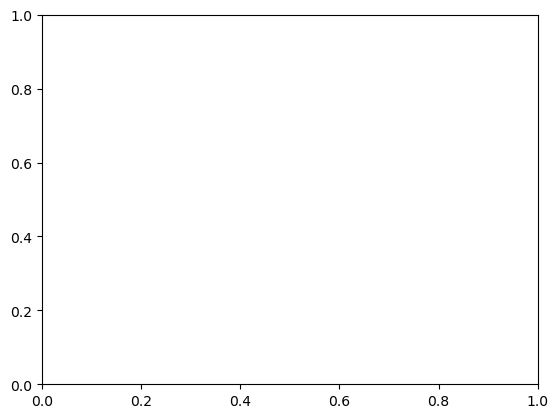

In [107]:
#l2 reg
estimator = SGDClassifier(loss='log_loss',
                           penalty='l2',
                           alpha=0.001,
                           max_iter=1,
                           eta0=0.01,
                           warm_start=True,
                           learning_rate='constant',
                           random_state=1729)
pipe_sgd_l2 = make_pipeline(MinMaxScaler(),estimator)
iterations=100
for i in range(iterations):
  pipe_sgd_l2.fit(X_train,y_train_0)
  y_pred = pipe_sgd_l2.predict_proba(X_train)
  Loss.append(log_loss(y_train_0,y_pred))
plt.figure()
plt.plot(np.arange(iterations),Loss)
plt.grid(True)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

In [108]:
weights = pipe_sgd_l2[1].coef_
bias = pipe_sgd_l2[1].intercept_
print(bias)

[-4.43001892]


In [109]:
num_zero_w = weights.shape[1]-np.count_nonzero(weights)
print('Number of weights with value zero:%f'%num_zero_w)

Number of weights with value zero:67.000000


In [111]:
print('Training accuracy %.2f'%pipe_sgd_l2.score(X_train,y_train_0))
print('Testing accuracy %.2f'%pipe_sgd_l2.score(X_test,y_test_0))

Training accuracy 0.99
Testing accuracy 0.99


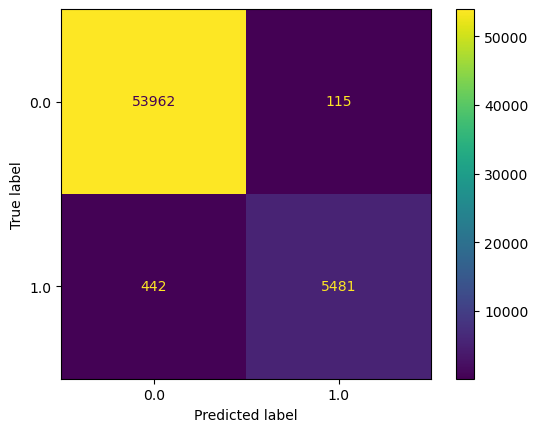

In [113]:
y_hat_train_0 = pipe_sgd_l2.predict(X_train)
cm_display = ConfusionMatrixDisplay.from_predictions(y_train_0,y_hat_train_0,values_format='.5g') # it return matplotlin plot object
plt.show()

In [114]:
print(classification_report(y_test_0, y_hat_test_0))

              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00      9020
         1.0       0.95      0.97      0.96       980

    accuracy                           0.99     10000
   macro avg       0.97      0.98      0.98     10000
weighted avg       0.99      0.99      0.99     10000



### displaying input image and its prediction

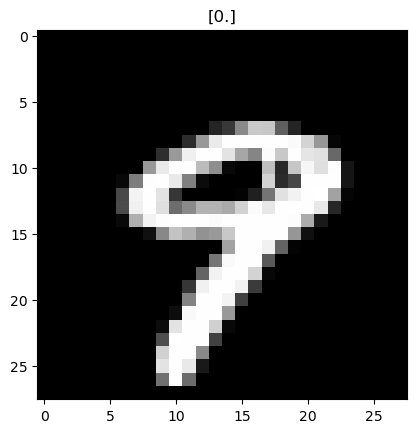

In [118]:
index=9
plt.imshow(X_test[index,:].reshape(28,28),cmap="gray")
pred = sgd_pipe.predict(X_test[index].reshape(1,-1))
plt.title(str(pred))
plt.show()

### Hyper parameter tuning

- hyperparameters: learning rate and regularization rate
- use of RandomizedCV

In [122]:
eta_grid=loguniform(1e-3,1e-1)
alpha_grid=loguniform(1e-7,1e-1)

estimator= SGDClassifier(loss='log_loss',
                        penalty='l2',
                        max_iter=100,
                        warm_start=False,
                        learning_rate='constant',
                        eta0=0.01,
                        alpha=0,
                        random_state=1729)

pipe_sgd_hpt = make_pipeline(MinMaxScaler(),estimator)

scores=RandomizedSearchCV(pipe_sgd_hpt,param_distributions={
    'sgdclassifier__eta0':eta_grid,
    'sgdclassifier__alpha':alpha_grid
}, cv=5,
                            scoring='precision',
                            n_iter=10,
                            refit=True,
                            random_state=1729)

scores.fit(X_train,y_train_0)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                                             ('sgdclassifier',
                                              SGDClassifier(alpha=0, eta0=0.01,
                                                            learning_rate='constant',
                                                            loss='log_loss',
                                                            max_iter=100,
                                                            random_state=1729))]),
                   param_distributions={'sgdclassifier__alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x28b8689b0>,
                                        'sgdclassifier__eta0': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x28b45f350>},
                   random_state=1729, scoring='precision')

In [123]:
print(scores.cv_results_)

{'mean_fit_time': array([2.00296588, 1.80125422, 1.50724945, 2.0743948 , 1.67133803,
       2.10523696, 2.28225832, 2.07359333, 1.61093383, 1.68309255]), 'std_fit_time': array([0.06981336, 0.10805744, 0.06193013, 0.07927723, 0.14056158,
       0.11320594, 0.12561486, 0.14793754, 0.04896127, 0.12997087]), 'mean_score_time': array([0.04752126, 0.03994942, 0.0469903 , 0.04700994, 0.04945736,
       0.05047393, 0.06153326, 0.06239552, 0.04964657, 0.05614781]), 'std_score_time': array([0.00668396, 0.00371441, 0.00884661, 0.00700521, 0.00443577,
       0.00325857, 0.00377453, 0.01810966, 0.00423613, 0.01719325]), 'param_sgdclassifier__alpha': masked_array(data=[1.8747854362378868e-06, 3.476412314661179e-05,
                   0.0014239854561506498, 5.312503633759699e-06,
                   0.05828730756092901, 2.521634683952945e-07,
                   0.00011448262369494136, 1.1186816059037773e-05,
                   0.05812154350589123, 0.0032689146207270374],
             mask=[False, Fals

In [124]:
scores.best_params_['sgdclassifier__alpha'],scores.best_params_['sgdclassifier__eta0']

(0.05812154350589123, 0.016908646693055966)

In [126]:
best_sgd_clf=scores.best_estimator_
y_hat_train_best_0=best_sgd_clf.predict(X_train)



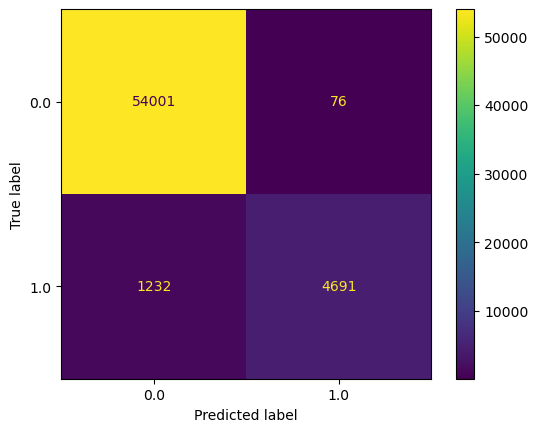

In [127]:
cm_display = ConfusionMatrixDisplay.from_predictions(y_train_0,y_hat_train_best_0,values_format='.5g') # it return matplotlin plot object
plt.show()

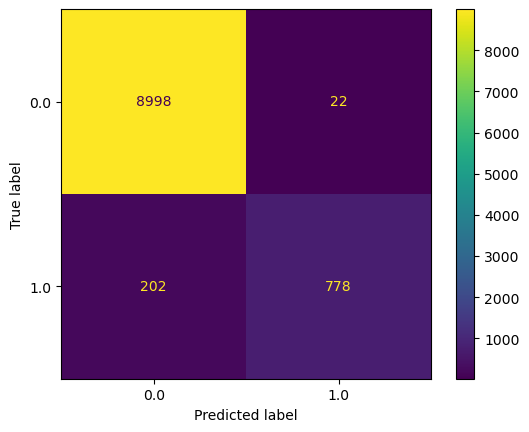

In [129]:
y_hat_test_best_0 = best_sgd_clf.predict(X_test)
cm_display = ConfusionMatrixDisplay.from_predictions(y_test_0,y_hat_test_best_0,values_format='.5g') # it return matplotlin plot object
plt.show()

In [130]:
print(classification_report(y_train_0,y_hat_train_best_0))

              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99     54077
         1.0       0.98      0.79      0.88      5923

    accuracy                           0.98     60000
   macro avg       0.98      0.90      0.93     60000
weighted avg       0.98      0.98      0.98     60000



In [131]:
print(classification_report(y_test_0,y_hat_test_best_0))

              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99      9020
         1.0       0.97      0.79      0.87       980

    accuracy                           0.98     10000
   macro avg       0.98      0.90      0.93     10000
weighted avg       0.98      0.98      0.98     10000



# Logistic Regression

In [7]:
logit_pipe=make_pipeline(MinMaxScaler(),LogisticRegression(random_state=1729,solver='lbfgs',C=np.inf))

logit_pipe.fit(X_train,y_train_0)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('logisticregression',
                 LogisticRegression(C=inf, random_state=1729))])

- <b>gridsearch</b> to search best value of C under certain scoring function

In [12]:
param_grid={
    'logisticregression__C':[0, 1e-4, 1e-3, 1e-2, 1e-1, 1.0, 10.0, 100.0]
}

logistic_grid=GridSearchCV(logit_pipe,param_grid=param_grid,scoring='f1')

logistic_grid.fit(X_train,y_train_0)


GridSearchCV(estimator=Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                                       ('logisticregression',
                                        LogisticRegression(C=inf,
                                                           random_state=1729))]),
             param_grid={'logisticregression__C': [0, 0.0001, 0.001, 0.01, 0.1,
                                                   1.0, 10.0, 100.0]},
             scoring='f1')

In [13]:
logistic_grid.best_params_

{'logisticregression__C': 0.1}

In [14]:
logistic_grid.best_score_

0.9582781080330685

In [15]:
logistic_grid.best_estimator_

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('logisticregression',
                 LogisticRegression(C=0.1, random_state=1729))])

- Instead of using gridsearchcv, we can also use LogisticRegressioncv for the same job

In [16]:
estimator=LogisticRegressionCV(cv=5,scoring='f1',random_state=42)
logitcv_=make_pipeline(MinMaxScaler(),estimator)
logitcv_.fit(X_train,y_train_0)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('logisticregressioncv',
                 LogisticRegressionCV(cv=5, random_state=42, scoring='f1'))])

## Performance Evaluation

-performances of 3 classifiers
- LogisticRegression without regularization
- best LogisticRegression with gridsearxh
- best classifier LogisticRegressioncv

In [18]:
lr_y_hat_0=logit_pipe.predict(X_test)
lr_y_hat_0_gs=logistic_grid.predict(X_test)
lr_y_hat_0_lcv=logitcv_.predict(X_test)

In [19]:
precision_lr=precision_score(y_test_0,lr_y_hat_0)
recall_lr=recall_score(y_test_0,lr_y_hat_0)

precision_lr_gs=precision_score(y_test_0,lr_y_hat_0_gs)
recall_lr_gs=recall_score(y_test_0,lr_y_hat_0_gs)

precision_lr_lcv=precision_score(y_test_0,lr_y_hat_0_lcv)
recall_lr_lcv=recall_score(y_test_0,lr_y_hat_0_lcv)


In [22]:
print(f"LogReg, precision:{precision_lr:.2f},recall:{recall_lr:.2f}")
print(f"LogReg_grid, precision:{precision_lr_gs:.2f},recall:{recall_lr_gs:.2f}")
print(f"LogReg_cv, precision:{precision_lr_lcv:.2f},recall:{recall_lr_lcv:.2f}")

LogReg, precision:0.95,recall:0.96
LogReg_grid, precision:0.96,recall:0.97
LogReg_cv, precision:0.95,recall:0.97


## Using the PR curve

In [24]:
y_scores_lr= logit_pipe.decision_function(X_test)
precisions_lr, recalls_lr, thresholds_lr = precision_recall_curve(
    y_test_0, y_scores_lr)

y_scores_lr_gs = logistic_grid.decision_function(X_test)
precisions_lr_gs, recalls_lr_gs, thresholds_lr_gs = precision_recall_curve(
    y_test_0, y_scores_lr_gs)

y_scores_lr_cv = logitcv_.decision_function(X_test)
precisions_lr_cv, recalls_lr_cv, thresholds_lr_cv = precision_recall_curve(
    y_test_0, y_scores_lr_cv)

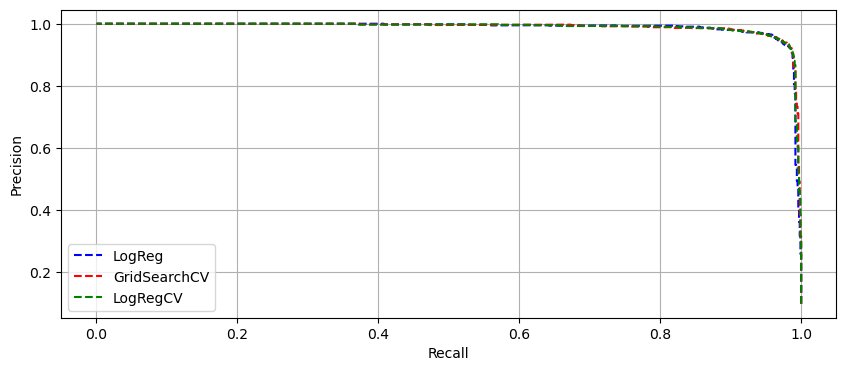

In [27]:
plt.figure(figsize=(10,4))
plt.plot(recalls_lr[:-1], precisions_lr[:-1], 'b--', label='LogReg')
plt.plot(recalls_lr_gs[:-1], precisions_lr_gs[:-1], 'r--', label='GridSearchCV')
plt.plot(recalls_lr_cv[:-1], precisions_lr_cv[:-1], 'g--', label='LogRegCV')

plt.ylabel('Precision')
plt.xlabel('Recall')
plt.grid(True)
plt.legend(loc='lower left')
plt.show()

In [30]:
from sklearn.metrics import auc

auc_lr = auc(recalls_lr[:-1], precisions_lr[:-1])
auc_lr_gs = auc(recalls_lr_gs[:-1], precisions_lr_gs[:-1])
auc_lr_cv = auc(recalls_lr_cv[:-1], precisions_lr_cv[:-1])

In [31]:
print ("AUC-PR for logistic regression:", auc_lr)
print ("AUC-PR for grid search:", auc_lr_gs)
print ("AUC-PR for logistic regression CV:", auc_lr_cv)

AUC-PR for logistic regression: 0.9872513414335629
AUC-PR for grid search: 0.9884540467590757
AUC-PR for logistic regression CV: 0.9882682337599971


# Ridge Classifier

- casts the problem as <b>least-squares classifiation </b> and finds the optimal weight using some matrix decomposition technique like SVD
- to train a ridge classifier the labels should be {-1,1}
- default L2 regularization 

In [35]:
y_train_0=-1*np.ones(len(y_train))
y_test_0=-1*np.ones(len(y_test))

idx1=np.where(y_train=='0')
idx2=np.where(y_test=='0')
y_train_0[idx1]=1
y_test_0[idx2]=1

In [36]:
#lets train a model with no regularization first
estimator=RidgeClassifier(alpha=0) 
pipe_ridge=make_pipeline(MinMaxScaler(),estimator)
pipe_ridge.fit(X_train,y_train_0)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('ridgeclassifier', RidgeClassifier(alpha=0))])

In [38]:
#performance
y_hat_test_0=pipe_ridge.predict(X_test)
print(classification_report(y_test_0,y_hat_test_0))

              precision    recall  f1-score   support

        -1.0       0.99      1.00      0.99      9020
         1.0       0.96      0.88      0.92       980

    accuracy                           0.98     10000
   macro avg       0.97      0.94      0.95     10000
weighted avg       0.98      0.98      0.98     10000



### cross validation

In [40]:
cv_bin_ridge_clf=cross_validate(
    pipe_ridge,X_train,y_train_0,cv=5,scoring=['precision','recall','f1'],return_train_score=True, return_estimator=True
)
print(cv_bin_ridge_clf)

{'fit_time': array([7.83779001, 7.25201511, 7.055758  , 7.09875512, 7.05818915]), 'score_time': array([0.08487916, 0.08042002, 0.07751083, 0.075423  , 0.07762289]), 'estimator': [Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('ridgeclassifier', RidgeClassifier(alpha=0))]), Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('ridgeclassifier', RidgeClassifier(alpha=0))]), Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('ridgeclassifier', RidgeClassifier(alpha=0))]), Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('ridgeclassifier', RidgeClassifier(alpha=0))]), Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('ridgeclassifier', RidgeClassifier(alpha=0))])], 'test_precision': array([0.96030978, 0.9374425 , 0.96619718, 0.95920304, 0.96551724]), 'train_precision': array([0.96560197, 0.96424371, 0.96533146, 0.96775701, 0.96513545]), 'test_recall': array([0.83783784, 0.86064189, 0.86835443, 0.85316456, 

In [43]:
best_estimator_id =np.argmax(cv_bin_ridge_clf['train_f1'])
best_estimator=cv_bin_ridge_clf['estimator'][best_estimator_id]

In [44]:
y_hat_test_0 = best_estimator.predict(X_test)
print(classification_report(y_test_0,y_hat_test_0))

              precision    recall  f1-score   support

        -1.0       0.99      1.00      0.99      9020
         1.0       0.95      0.88      0.91       980

    accuracy                           0.98     10000
   macro avg       0.97      0.94      0.95     10000
weighted avg       0.98      0.98      0.98     10000

